# Install Library

In [1]:
!pip install arch -q
!git clone https://github.com/numenta/NAB.git -q

fatal: destination path 'NAB' already exists and is not an empty directory.


# Define sRLSTM + AutoEncoder Ensenble Model

In [2]:
import os
import numpy as np
import torch
import torch.nn as nn
import random
import torch.optim as optim

class sRLSTMCell(nn.Module):
    def __init__(self, input_size, hidden_size, forget_bias=1.0, dense=None,
                 file_name='h1', type='enc', component=1, partition=1, seed=None, skip_steps=1):
        super(sRLSTMCell, self).__init__()
        self.hidden_size = hidden_size
        self.forget_bias = forget_bias
        self.file_name = file_name
        self.type = type
        self.component = component
        self.partition = partition
        self.step = 0  # Equivalent to TensorFlow's _step
        self.skip_steps = skip_steps  # 스킵 스텝 추가

        # Initialize the main LSTM cell
        self.lstm = nn.LSTMCell(input_size, hidden_size)

        # Initialize additional weights and biases
        self.weight_h_2 = nn.Parameter(torch.Tensor(hidden_size, hidden_size))
        self.bias_h_2 = nn.Parameter(torch.Tensor(hidden_size))
        nn.init.trunc_normal_(self.weight_h_2, std=0.1)
        nn.init.zeros_(self.bias_h_2)

        # Activation function
        self.activation = torch.tanh

        # Initialize directories for saving masks
        self._init_directories()

        # Initialize mask generator
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        else:
            self.rng = np.random.RandomState()

        # Buffer to store past hidden states for skip connection
        self.hidden_buffer = []

    def _init_directories(self):
        base_dir = f'./weight/{self.file_name}/{self.partition}/{self.component}/{self.type}'
        os.makedirs(base_dir, exist_ok=True)
        self.mask_dir = base_dir

    def masked_weight(self, load=False):
        mask_w1_path = os.path.join(self.mask_dir, f'W1_step_{self.step}.npy')
        mask_w2_path = os.path.join(self.mask_dir, f'W2_step_{self.step}.npy')

        if not load:
            # Generate masks with (1,0), (0,1), (1,1)
            mask_combined = self.rng.randint(0, 3, size=self.hidden_size)
            masked_W1 = (mask_combined == 0) | (mask_combined == 2)
            masked_W2 = (mask_combined == 1) | (mask_combined == 2)

            masked_W1 = masked_W1.astype(np.float32)
            masked_W2 = masked_W2.astype(np.float32)

            # Save masks
            np.save(mask_w1_path, masked_W1)
            np.save(mask_w2_path, masked_W2)
        else:
            # Load masks
            if os.path.exists(mask_w1_path) and os.path.exists(mask_w2_path):
                masked_W1 = np.load(mask_w1_path)
                masked_W2 = np.load(mask_w2_path)
            else:
                # If masks do not exist, generate them
                mask_combined = self.rng.randint(0, 3, size=self.hidden_size)
                masked_W1 = (mask_combined == 0) | (mask_combined == 2)
                masked_W2 = (mask_combined == 1) | (mask_combined == 2)

                masked_W1 = masked_W1.astype(np.float32)
                masked_W2 = masked_W2.astype(np.float32)

                np.save(mask_w1_path, masked_W1)
                np.save(mask_w2_path, masked_W2)

        # Convert masks to torch tensors
        tf_mask_W1 = torch.tensor(masked_W1, dtype=torch.float32, device=self.weight_h_2.device)
        tf_mask_W2 = torch.tensor(masked_W2, dtype=torch.float32, device=self.weight_h_2.device)
        return tf_mask_W1, tf_mask_W2

    def forward(self, input, state, load_mask=None):
        """
        Args:
            input: Tensor of shape (batch_size, input_size)
            state: Tuple of (h, c), each of shape (batch_size, hidden_size)
            load_mask: Boolean indicating whether to load masks from files
        Returns:
            h: New hidden state
            new_state: Tuple of (new_h, new_c)
        """
        h, c = state
        self.step += 1

        # Compute LSTM cell output
        new_h_1, new_c = self.lstm(input, (h, c))

        # Update hidden buffer
        self.hidden_buffer.append(h.detach())
        if len(self.hidden_buffer) > self.skip_steps:
            h_skip = self.hidden_buffer.pop(0)
        else:
            h_skip = torch.zeros_like(h)  # 초기화: 충분한 이전 스텝이 없을 경우 0으로 채움

        # Compute new_h_2 using skip connection
        new_h_2 = torch.sigmoid(torch.matmul(h_skip, self.weight_h_2) + self.bias_h_2)

        # Determine whether to load masks based on load_mask parameter
        if load_mask is None:
            load_mask = not self.training  # Automatically set load_mask based on training mode

        # Get masks
        mask_w1, mask_w2 = self.masked_weight(load=load_mask)

        # Apply masks with (1,0), (0,1), (1,1) mapping
        new_h = new_h_1 * mask_w1 + new_h_2 * mask_w2

        new_state = (new_h, new_c)
        return new_h, new_state

    def reset_step(self):
        """Reset the step counter."""
        self.step = 0

    def save_masks(self):
        """Save current masks to files."""
        mask_w1, mask_w2 = self.masked_weight(load=False)
        # Masks are already saved in masked_weight when load=False
        # So no additional action is needed here
        pass

    def load_masks(self):
        """Load masks from files for the current step."""
        mask_w1, mask_w2 = self.masked_weight(load=True)
        return mask_w1, mask_w2

class Encoder(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers=1, skip_steps=1, file_name='enc', partition=1, **kwargs):
        super(Encoder, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # sRLSTMCell을 다층 구조로 사용하기 위해 ModuleList로 저장
        self.cells = nn.ModuleList([
            sRLSTMCell(
                input_size if i == 0 else hidden_size,
                hidden_size,
                type='enc',
                component=i+1,
                partition=partition,
                file_name=file_name,
                skip_steps=skip_steps,
                **kwargs
            )
            for i in range(num_layers)
        ])

    def forward(self, inputs, load_mask=None):
        """
        Args:
            inputs: Tensor of shape (seq_len, batch_size, input_size)
            load_mask: Boolean indicating whether to load masks from files
        Returns:
            outputs: List of final hidden states for each layer
            states: List of final (h, c) tuples for each layer
        """
        batch_size = inputs.size(1)
        seq_len = inputs.size(0)

        # 초기 은닉 상태와 셀 상태를 0으로 초기화
        h = [torch.zeros(batch_size, self.hidden_size, device=inputs.device) for _ in range(self.num_layers)]
        c = [torch.zeros(batch_size, self.hidden_size, device=inputs.device) for _ in range(self.num_layers)]
        states = list(zip(h, c))

        # 각 타임스텝에 대해 순환
        for t in range(seq_len):
            input_t = inputs[t]
            for i, cell in enumerate(self.cells):
                h_i, c_i = states[i]
                h_i, (h_i, c_i) = cell(input_t, (h_i, c_i), load_mask=load_mask)
                states[i] = (h_i, c_i)
                input_t = h_i  # 다음 레이어의 입력으로 현재 레이어의 출력을 사용
        outputs = [state[0] for state in states]  # 각 레이어의 마지막 은닉 상태
        return outputs, states

class Decoder(nn.Module):
    def __init__(self, hidden_size, output_size, num_layers=1, skip_steps=1, file_name='dec', partition=1, **kwargs):
        super(Decoder, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        # sRLSTMCell을 다층 구조로 사용하기 위해 ModuleList로 저장
        self.cells = nn.ModuleList([
            sRLSTMCell(
                output_size if i == 0 else hidden_size,
                hidden_size,
                type='dec',
                component=i+1,
                partition=partition,
                file_name=file_name,
                skip_steps=skip_steps,
                **kwargs
            )
            for i in range(num_layers)
        ])
        # 최종 출력을 위한 선형 레이어
        self.output_layer = nn.Linear(hidden_size, output_size)

    def forward(self, targets, encoder_states, load_mask=None):
        """
        Args:
            targets: Tensor of shape (seq_len, batch_size, output_size)
            encoder_states: List of (h, c) tuples from the encoder
            load_mask: Boolean indicating whether to load masks from files
        Returns:
            outputs: Reconstructed outputs of shape (seq_len, batch_size, output_size)
        """
        batch_size = targets.size(1)
        seq_len = targets.size(0)

        # 인코더의 마지막 상태를 디코더의 초기 상태로 사용
        h = [state[0].detach() for state in encoder_states]  # detach to prevent gradients flowing back to encoder
        c = [state[1].detach() for state in encoder_states]
        states = list(zip(h, c))

        outputs = []
        # 각 타임스텝에 대해 순환
        for t in range(seq_len):
            input_t = targets[t]
            for i, cell in enumerate(self.cells):
                h_i, c_i = states[i]
                h_i, (h_i, c_i) = cell(input_t, (h_i, c_i), load_mask=load_mask)
                states[i] = (h_i, c_i)
                input_t = h_i  # 다음 레이어의 입력으로 현재 레이어의 출력을 사용
            output_t = self.output_layer(input_t)
            outputs.append(output_t)
        outputs = torch.stack(outputs, dim=0)
        return outputs

class AutoEncoder(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, skip_steps=1, 
                 file_name_enc='enc', file_name_dec='dec', partition=1, **kwargs):
        super(AutoEncoder, self).__init__()
        self.encoder = Encoder(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            skip_steps=skip_steps, 
            file_name=file_name_enc,
            partition=partition,
            **kwargs
        )
        self.decoder = Decoder(
            hidden_size=hidden_size, 
            output_size=output_size, 
            num_layers=num_layers, 
            skip_steps=skip_steps,
            file_name=file_name_dec,
            partition=partition,
            **kwargs
        )

    def forward(self, inputs, targets, load_mask=None):
        """
        Args:
            inputs: Tensor of shape (seq_len, batch_size, input_size)
            targets: Tensor of shape (seq_len, batch_size, output_size)
            load_mask: Boolean indicating whether to load masks from files
        Returns:
            outputs: Reconstructed outputs of shape (seq_len, batch_size, output_size)
        """
        encoder_outputs, encoder_states = self.encoder(inputs, load_mask=load_mask)
        outputs = self.decoder(targets, encoder_states, load_mask=load_mask)
        return outputs

class EnsembleAutoEncoder(nn.Module):
    def __init__(self, N, input_size, hidden_size, output_size, num_layers=1, limit_skip_steps=2, 
                 file_names=None, **kwargs):
        """
        Args:
            N: Number of AutoEncoders in the ensemble
            input_size: Size of the input features
            hidden_size: Size of the hidden state in LSTM
            output_size: Size of the output features
            num_layers: Number of layers in each AutoEncoder
            limit_skip_steps: Maximum value for skip_steps (e.g., 2 means skip_steps can be 1 or 2)
            file_names: List of file_names for each AutoEncoder. Length should be N.
            **kwargs: Additional keyword arguments for sRLSTMCell
        """
        super(EnsembleAutoEncoder, self).__init__()
        self.N = N
        self.autoencoders = nn.ModuleList()
        
        # 기본 파일 이름 설정
        if file_names is None:
            file_names = [f'autoencoder_{i}' for i in range(N)]
        elif len(file_names) != N:
            raise ValueError("Length of file_names must be equal to N")
        
        for idx in range(N):
            # Randomly choose skip_steps from 1 to limit_skip_steps for each AutoEncoder
            random_skip_steps = random.choice([i for i in range(1, limit_skip_steps+1)])
            
            # 수동으로 설정된 file_name을 기반으로 인코더와 디코더의 file_name 생성
            file_name_enc = f'{file_names[idx]}_enc'
            file_name_dec = f'{file_names[idx]}_dec'
            
            # 파티션 번호는 AutoEncoder 인덱스 +1로 설정
            partition = idx + 1
            
            autoencoder = AutoEncoder(
                input_size=input_size,
                hidden_size=hidden_size,
                output_size=output_size,
                num_layers=num_layers,
                skip_steps=random_skip_steps,
                file_name_enc=file_name_enc,
                file_name_dec=file_name_dec,
                partition=partition,
                **kwargs
            )
            self.autoencoders.append(autoencoder)

    def forward(self, inputs, targets, load_mask=None):
        """
        Args:
            inputs: Tensor of shape (seq_len, batch_size, input_size)
            targets: Tensor of shape (seq_len, batch_size, output_size)
            load_mask: Boolean indicating whether to load masks from files
        Returns:
            outputs: Averaged reconstructed outputs of shape (seq_len, batch_size, output_size)
        """
        ensemble_outputs = []
        for autoencoder in self.autoencoders:
            output = autoencoder(inputs, targets, load_mask=load_mask)
            ensemble_outputs.append(output)
        # Stack and average the outputs
        stacked_outputs = torch.stack(ensemble_outputs, dim=0)  # Shape: (N, seq_len, batch_size, output_size)
        averaged_output = torch.mean(stacked_outputs, dim=0)    # Shape: (seq_len, batch_size, output_size)
        return averaged_output

    def reset_steps(self):
        """Reset step counters for all AutoEncoders in the ensemble."""
        for autoencoder in self.autoencoders:
            for cell in autoencoder.encoder.cells:
                cell.reset_step()
            for cell in autoencoder.decoder.cells:
                cell.reset_step()

def set_random_seed(seed):
    os.environ['PYTHONHASHSEED'] = str(seed)
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
    # 딥러닝 재현성을 위해 추가 설정
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False


In [11]:
# 랜덤 시드 설정
random_seed = 777

set_random_seed(random_seed)

"""
<Outlier Detection for Time Series with Recurrent Autoencoder Ensembles>
[Hyperparameters Settings]
For all deep learning based methods, we use
Adadelta [Zeiler, 2012] as the optimizer, and we set
their learning rates to 10−3.
...
we set the number of hidden LSTM units to 8;
we set the default number of autoencoders N to
40, and we also study the effect of varying N from 10 to 40;
and we set λ to 0.005.
...
For MP, we set the pattern size to 10. # I think MP is Markov Process, and the pattern size is the state space of MP.
"""

# 하이퍼파라미터 설정
N = 10  # 앙상블 모델 수, 10 or 40
input_size = 1  # 단일 시계열
hidden_size = 8
output_size = 1
num_layers = 2
L = 3
file_names = [f'model{i}' for i in range(N)]

model = EnsembleAutoEncoder(
    N=N, 
    input_size=input_size,
    hidden_size=hidden_size,
    output_size=output_size,
    num_layers=num_layers,
    limit_skip_steps=L,
    file_names=file_names,
    seed=random_seed
)

# 학습 파라미터 설정 (epoch 수는 수정, 다른 파라미터는 고정)

learning_rate = 1e-3
l1_lambda = 0.005  # L1 정규화 스케일

# 디바이스 설정 (GPU가 사용 가능하면 GPU, 아니면 CPU)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

# Test w/ sine wave data

In [12]:
# -------------------------------
# 3. 데이터 생성 (사인파 시퀀스)
# -------------------------------

def generate_sine_wave(seq_length, batch_size, input_size=1):
    """
    사인파 시퀀스를 생성합니다.
    
    Args:
        seq_length (int): 시퀀스의 길이 (타임 스텝 수)
        batch_size (int): 배치 크기
        input_size (int): 입력 피처의 수 (기본값: 1)
    
    Returns:
        np.ndarray: 생성된 사인파 데이터, shape (batch_size, seq_length, input_size)
    """
    x = np.linspace(0, 2 * np.pi, seq_length)
    data = []
    for _ in range(batch_size):
        phase = np.random.uniform(0, 2 * np.pi)
        amplitude = np.random.uniform(0.5, 1.5)
        sine_wave = amplitude * np.sin(x + phase)
        noise = np.random.normal(0, 0.1, size=x.shape)
        sine_wave += noise
        data.append(sine_wave)
    data = np.array(data)  # shape (batch_size, seq_length)
    data = data[..., np.newaxis]  # shape (batch_size, seq_length, 1)
    return data

# 데이터 파라미터 설정
seq_length = 20
batch_size = 32

# 입력과 타겟 데이터 생성
inputs = generate_sine_wave(seq_length, batch_size, input_size)
targets = generate_sine_wave(seq_length, batch_size, output_size)

# 텐서로 변환하고 시퀀스 차원 (seq_len, batch_size, input_size)으로 변환
inputs = torch.tensor(inputs, dtype=torch.float32).transpose(0, 1).to(device)
targets = torch.tensor(targets, dtype=torch.float32).transpose(0, 1).to(device)

# -------------------------------
# 4. 손실 함수 및 옵티마이저 정의
# -------------------------------

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# -------------------------------
# 5. 학습 루프 실행
# -------------------------------

model.train()
num_epochs = 250

for epoch in range(num_epochs):
    optimizer.zero_grad()
    
    # 순전파
    outputs = model(inputs, targets)
    
    # 손실 계산
    loss = criterion(outputs, targets)
    
    # 역전파
    loss.backward()
    optimizer.step()
    
    # 주기적으로 손실 출력
    if (epoch + 1) % 50 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# -------------------------------
# 6. 모델의 성능 평가
# -------------------------------

model.eval()
with torch.no_grad():
    # 테스트 데이터 생성
    test_inputs = generate_sine_wave(seq_length, batch_size, input_size)
    test_targets = generate_sine_wave(seq_length, batch_size, output_size)
    
    # 텐서로 변환하고 시퀀스 차원으로 변환
    test_inputs = torch.tensor(test_inputs, dtype=torch.float32).transpose(0, 1).to(device)
    test_targets = torch.tensor(test_targets, dtype=torch.float32).transpose(0, 1).to(device)
    
    # 순전파
    test_outputs = model(test_inputs, test_targets)
    
    # 손실 계산
    test_loss = criterion(test_outputs, test_targets)
    print(f'Test Loss: {test_loss.item():.4f}')

Epoch [50/250], Loss: 0.4606
Epoch [100/250], Loss: 0.3927
Epoch [150/250], Loss: 0.1926
Epoch [200/250], Loss: 0.0983
Epoch [250/250], Loss: 0.0852
Test Loss: 0.0755


In [13]:
# 모델 가중치 저장
torch.save(model.state_dict(), 'ensemble_autoencoder_weights.pth')
print("모델 가중치가 'ensemble_autoencoder_weights.pth'에 저장되었습니다.")

모델 가중치가 'ensemble_autoencoder_weights.pth'에 저장되었습니다.


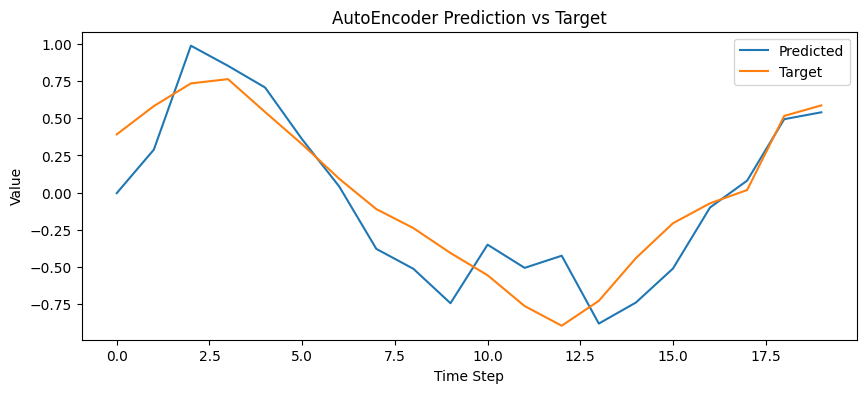

In [14]:
import matplotlib.pyplot as plt

with torch.no_grad():
    # 첫 번째 배치의 첫 번째 시퀀스를 선택
    pred = test_outputs[:, 0, 0].cpu().numpy()
    target = test_targets[:, 0, 0].cpu().numpy()
    
    plt.figure(figsize=(10, 4))
    plt.plot(pred, label='Predicted')
    plt.plot(target, label='Target')
    plt.legend()
    plt.title('AutoEncoder Prediction vs Target')
    plt.xlabel('Time Step')
    plt.ylabel('Value')
    plt.show()